# DATA EXPLORATION, CLEANING AND IMPUTATION

### Loading libraries

In [208]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.10f}'.format

### MISSING VALUE VISUALIZATION
import missingno as msno

### DATA PLOTTING
import matplotlib.pyplot as plt
import seaborn as sns

### DATA PREPROCESSING
from functions import *

### IMPUTATION
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

### ENCODING
from sklearn.preprocessing import LabelEncoder

#### Loading data
First and second column are unique ID's so we keep only the smallest one to save memory space

In [209]:
test = pd.read_csv('./data/properties_colombia_test.csv', sep = ',')
test.drop('id', axis=1, inplace=True)
test.rename(columns={'Unnamed: 0':'id'}, inplace=True)
test.set_index('id', inplace=True)

In [210]:
test.shape

(65850, 24)

In [211]:
todrop = ['operation_type', 'currency', 'created_on', 'price_period', 'l1', 'ad_type']
test.drop(todrop, axis=1, inplace=True)
test = trim_all_columns(test)
test['title'] = normalize_column(test, 'title')
test['description'] = normalize_column(test, 'description')
test['title'] = test['title'].str.lower().str.strip()
test['description'] = test['description'].str.lower().str.strip()
pattern = '|'.join(['\n','\r', '\t' ,'\xa0','\u200b',','])
test['title'] = clean_values(test['title'], pattern, value=' ')
test['description'] = clean_values(test['description'], pattern, value=' ')
pattern2 = '|'.join(['_', '[(|)]', '-',':',';'])
test['title'] = clean_values(test['title'], pattern2, regex = True, value=' ')
test['description'] = clean_values(test['description'], pattern2, regex = True, value=' ')
test['title'] = clean_values(test['title'], r"\<.*?\>", regex = True, value=' ')
test['description'] = clean_values(test['description'], pattern2, regex = True, value=' ')
test['title'] = clean_values(test['title'], r"\{.*?\}", regex = True, value=' ')
test['description'] = clean_values(test['description'], pattern2, regex = True, value=' ')
test['title'] = test['title'].str.replace(' +',' ', regex=True)
test['description'] = test['description'].str.replace(' +',' ', regex = True)


regex = r"(\d+\.?\d+(?=m2| m2| mts2| metros cuadrados| mts))"
mask1 = test.loc[:,'title'].str.extract(regex, expand = False).notna()
mask2 = test.loc[:,'description'].str.extract(regex, expand = False).notna()
mask_na = test['surface_total'].isna()
test.loc[mask_na & mask1, 'surface_total'] = test.loc[mask_na & mask1, 'title'].str.extract(regex, expand = False)
test.loc[mask_na & mask2, 'surface_total'] = test.loc[mask_na & mask2, 'description'].str.extract(regex, expand = False)

mask1 = test['surface_total'].isna()
mask2 = test['surface_covered'].notna()
test.loc[mask1 & mask2,'surface_total'] = test.loc[mask1 & mask2,'surface_covered']

regex = r"(\d+\.?\d+(?=hectareas| hectareas|hectáreas| hectáreas|hectárea| hectárea|hectare| hectare|has| has))"
indexes = test.loc[:,'description'].str.extract(regex, expand = False).dropna().astype(float).sort_values(ascending = False).index.tolist()
test.loc[indexes, 'surface_total'] = test.loc[indexes,'description'].str.extract(regex, expand = False).dropna().astype(float).mul(10000)

test['surface_total'] = pd.to_numeric(test['surface_total'], errors='coerce')

value = '|'.join(['pileta', 'piscina','natatorio'])
test['pileta'] = test['description'].str.contains(value, regex = True, case = False)
test['pileta'].fillna(False, inplace=True)

value = '|'.join(['vigilancia 24', 'porteria 24', 'seguridad 24', 'vigilancia las 24', 'porteria las 24', 'seguridad las 24'])
test['vigilancia'] = test['description'].str.contains(value, regex = True, case = False)
test['vigilancia'].fillna(False, inplace=True)

value = '|'.join(['patio', 'jardin', 'parque'])
test['patio'] = test['description'].str.contains(value, regex = True, case = False)
test['patio'].fillna(False, inplace=True)

value = '|'.join(['garage', 'garaje', 'cochera', 'parquedero'])
test['garage'] = test['description'].str.contains(value, regex = True, case = False)
test['garage'].fillna(False, inplace=True)

value = '|'.join(['balcon', 'balcn', 'valcon'])
test['balcon'] = test['description'].str.contains(value, regex = True, case = False)
test['balcon'].fillna(False, inplace=True)

value = '|'.join(['cancha'])
test['cancha'] = test['description'].str.contains(value, regex = True, case = False)
test['cancha'].fillna(False, inplace=True)

value = '|'.join(['gimnasio', 'gym', 'gim', 'fitnes'])
test['gimnasio'] = test['description'].str.contains(value, regex = True, case = False)
test['gimnasio'].fillna(False, inplace=True)

value = '|'.join(['sauna', 'solarium', 'ducha turca', 'ducha escocesa'])
test['sauna'] = test['description'].str.contains(value, regex = True, case = False)
test['sauna'].fillna(False, inplace=True)

value = '|'.join(['estren'])
test['a_estrenar'] = test['description'].str.contains(value, regex = True, case = False)
test['a_estrenar'].fillna(False, inplace=True)

regex = r"(\d+(?=bano| bano|banio| banio))"
mask = test.loc[:,'bathrooms'].isna()
test.loc[mask, 'bathrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)
test['bathrooms'] = pd.to_numeric(test['bathrooms'], errors = 'coerce')
test['bathrooms_cat'] = pd.cut(test['bathrooms'], bins = [0,1,2,3,np.inf], labels = ['0','1','2','3 o mas'])

regex = r'(\d+(?=habitac| habitac |alcob| alcob|cuart| cuart))'
mask = test.loc[:,'bedrooms'].isna()
test.loc[mask, 'bedrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)
test['bedrooms'] = pd.to_numeric(test['bedrooms'], errors = 'coerce')
test['bedrooms_cat'] = pd.cut(test['bedrooms'], bins = [0,1,2,3,np.inf], labels = ['0','1','2','3 o mas'])

test.drop('geometry', axis = 1, inplace = True)
mask_l2 = test.loc[:,'l2'].notna()
mask_l3 = test.loc[:,'l3'].notna()
mask_l4 = test.loc[:,'l4'].notna()
mask_l5 = test.loc[:,'l5'].notna()
mask_l6 = test.loc[:,'l6'].notna()
mask_lat = test.loc[:,'lat'].isna()
mask_lon = test.loc[:,'lon'].isna()

locations_gps = pd.read_csv('./data/gps/locations_all_df_google.csv')
test['full_location'] = test.agg(lambda x: f"{x['l6']},{x['l5']},{x['l4']},{x['l3']},{x['l2']},Colombia", axis=1)
test['full_location'] = test['full_location'].str.replace('nan,','')
test = test.merge(locations_gps, how='left',  left_on='full_location', right_on='l_all', suffixes=('', '_new'))
test['lat'] = np.where(test['lat'].isna(), test['lat_new'], test['lat'])
test['lon'] = np.where(test['lon'].isna(), test['lon_new'], test['lon'])
todrop = ['full_location', 'l_all', 'lat_new', 'lon_new']
test.drop(todrop, axis = 1, inplace = True)

test['end_date'] = pd.to_datetime(test['end_date'], errors = 'coerce')
test['start_date'] = pd.to_datetime(test['start_date'], errors = 'coerce')
test['days_published'] = test['end_date'] - test['start_date']
test['days_published'] = test['days_published'].dt.days
test.drop('end_date', axis = 1, inplace = True)

todrop = ['bedrooms', 'rooms', 'bathrooms','surface_covered', 'l4', 'l5', 'l6', 'title', 'description']
test_before_drop = test.copy()
test.drop(todrop, axis = 1, inplace = True)

test['l2'].fillna('NA', inplace = True)
test['l3'].fillna('NA', inplace = True)
test['property_type'].fillna(test['property_type'].mode()[0], inplace = True)

cat_encode = [
 'pileta',
 'vigilancia',
 'patio',
 'garage',
 'balcon',
 'cancha',
 'gimnasio',
 'sauna',
 'a_estrenar',
 'bathrooms_cat',
 'bedrooms_cat']

le = LabelEncoder()
test[cat_encode] = test[cat_encode].apply(lambda x: le.fit_transform(x))

test['surface_total'] = test['surface_total'].astype(float)
test['start_date'].fillna(test['start_date'].mode()[0], inplace = True)

lista_na = test.loc[:, test.isna().any()].columns.tolist()
test_mice = test.filter(lista_na, axis=1).copy()
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(test_mice), columns=test_mice.columns)
test[df_mice_imputed.columns.tolist()] = df_mice_imputed

In [212]:
test.shape

(65850, 19)

In [214]:
test.to_csv('./data/cleaned/test_cleaned_imputed.csv', index = True)

In [217]:
distance_test = pd.read_csv('./data/distances_test.csv')

In [218]:
test['distance_shore'] = distance_test['coast_dist']

In [219]:
test.to_csv('./data/cleaned/test_final.csv', index = True)

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(test)
profile.to_file("reporte_test.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/maico/Henry/DeepLearning/lib/python3.10/site-packages/multimethod/__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(*args, **kwargs)
/Users/maico/Henry/DeepLearning/lib/python3.10/site-packages/multimethod/__init__.py:315: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  return func(*args, **kwargs)
/Users/maico/Henry/DeepLearning/lib/python3.10/site-packages/multimethod/__init__.py:315: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return func(*args, **kwargs)
/Users/maico/Henry/DeepLearning/lib/python3.10/site-pa

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## EXPLORATORY ANALYSIS WITH TARGET FEATURE

## CORRELATION PLOT

/var/folders/4p/6ylhcrld3b708sdcx7l8k0_w0000gn/T/ipykernel_13780/3056233577.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(method='spearman'), annot=True, fmt='.1g', cmap='coolwarm')


<AxesSubplot:>

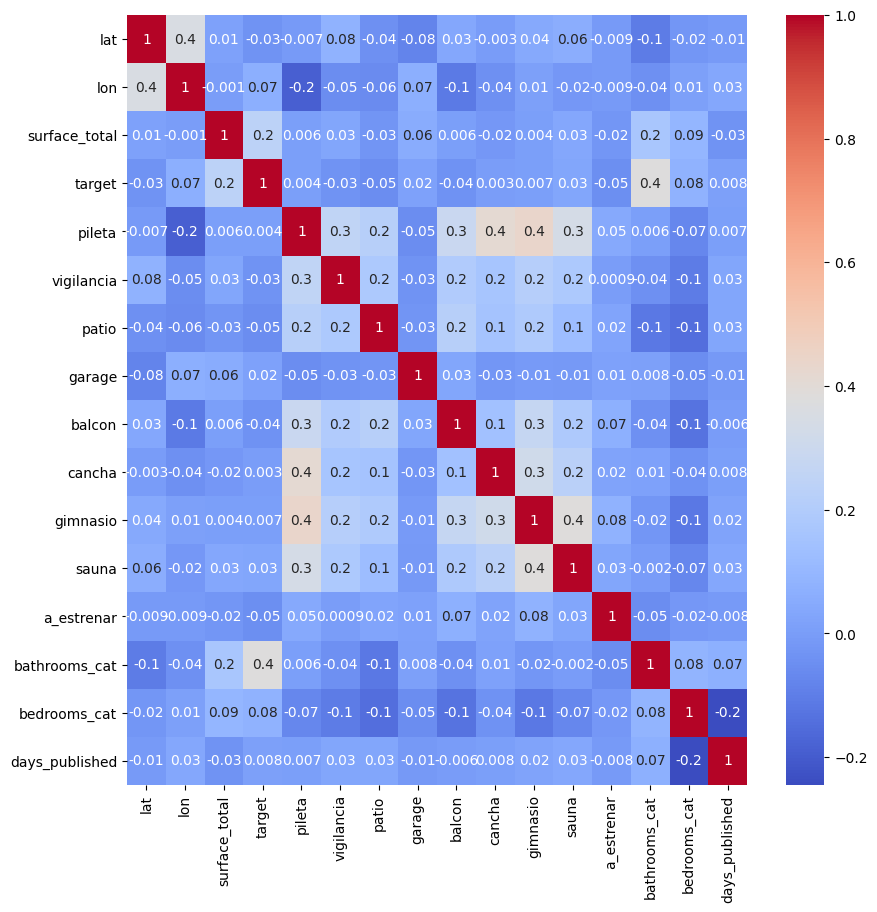

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(test.corr(method='spearman'), annot=True, fmt='.1g', cmap='coolwarm')

In [ ]:
test.describe()

,lat,lon,surface_total,target,pileta,vigilancia,patio,garage,balcon,cancha,gimnasio,sauna,a_estrenar,bathrooms_cat,bedrooms_cat,days_published
count,111371.00,111371.00,111371.00,111371.00,111371.00,111371.00,111371.00,111371.00,111371.00,111371.00,111371.00,111371.00,111371.00,111371.00,111371.00,111371.00
mean,5.73,-75.05,12762054.02,0.25,0.24,0.14,0.62,0.16,0.25,0.11,0.15,0.06,0.05,1.99,3.01,59.83
std,2.22,1.06,1204867801.04,0.43,0.43,0.35,0.49,0.36,0.44,0.31,0.36,0.24,0.21,1.35,1.15,69.93
min,-32.79,-119.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4.60,-75.63,135.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,4.00
50%,4.92,-75.48,12762053.95,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,4.00,45.00
75%,6.25,-74.10,12762053.98,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,3.00,4.00,88.00
max,34.42,-67.48,297965560000.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,4.00,4.00,436.00


### TARGET by L2

In [ ]:
top = test_cleaned_imputed.groupby('l2').agg({'target':'sum'}).sort_values(by='target', ascending=False).head(10)
top

,target
l2,
Cundinamarca,9831
Antioquia,6572
Valle del Cauca,3649
Atlántico,1878
Risaralda,1266
Caldas,1145
Bolívar,674
Santander,671
Quindío,455


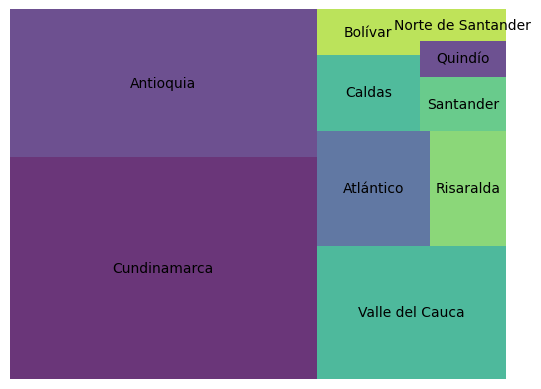

In [ ]:
import squarify
import matplotlib.pyplot as plt

squarify.plot(sizes=top['target'], label=top.index, alpha=.8 )
plt.axis('off')
plt.show()

### TARGET BY L3

In [ ]:
top = test_cleaned_imputed.groupby('l3').agg({'target':'sum'}).sort_values(by='target', ascending=False).head(10)
top

,target
l3,
Bogotá D.C,7384
Medellín,3280
Cali,2814
NA,2159
Barranquilla,1744
Envigado,1229
Chía,1017
Pereira,904
Manizales,880


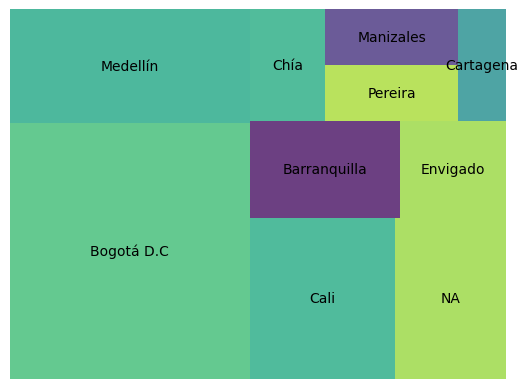

In [ ]:
squarify.plot(sizes=top['target'], label=top.index, alpha=.8 )
plt.axis('off')
plt.show()

## TARGET by SURFACE

In [ ]:
top = test_cleaned_imputed.groupby('target').agg({'surface_total':'mean'}).sort_values(by='surface_total', ascending=False).head(10)
top

,surface_total
target,
1,17540954.70
0,11165480.66


<AxesSubplot:xlabel='target'>

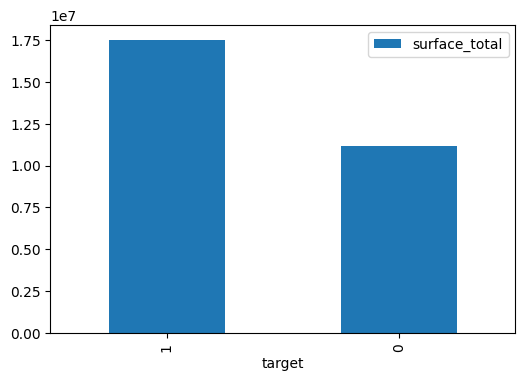

In [ ]:
top.plot(kind='bar', figsize=(6,4))

In [196]:
cat = ['property_type','pileta','vigilancia','patio','garage','balcon','cancha','gimnasio','sauna','a_estrenar','bathrooms_cat','bedrooms_cat']

subset = test.drop(['l2','l3','start_date','lat','lon'], axis=1)

In [197]:
from tableone import TableOne, load_dataset
#https://tableone.readthedocs.io/en/latest/quickstart.html

mytable = TableOne(subset, dip_test=True, normal_test=True, tukey_test=True, categorical = cat)

mytable.tableone

Missing                    Overall
n                                                                      65851
surface_total, mean (SD)                        0  13676470.7 (1161123264.8)
property_type, n (%)      Apartamento           0               33525 (50.9)
                          Casa                                  20084 (30.5)
                          Finca                                    377 (0.6)
                          Local comercial                          434 (0.7)
                          Lote                                    5704 (8.7)
                          Oficina                                  348 (0.5)
                          Otro                                    5372 (8.2)
                          Parqueadero                                7 (0.0)
pileta, n (%)             0                     0               50090 (76.1)
                          1                                     15733 (23.9)
                          2                                         28 (0.0)
vigilancia, n (%)         0                     0               56461 (85.7)
                          1                                      9362 (14.2)
                          2                                         28 (0.0)
patio, n (%)              0                     0               26052 (39.6)
                          1                                     39771 (60.4)
                          2                                         28 (0.0)
garage, n (%)             0                     0               55404 (84.1)
                          1                                     10419 (15.8)
                          2                                         28 (0.0)
balcon, n (%)             0                     0               47862 (72.7)
                          1                                     17961 (27.3)
                          2                                         28 (0.0)
cancha, n (%)             0                     0               58597 (89.0)
                          1                                      7226 (11.0)
                          2                                         28 (0.0)
gimnasio, n (%)           0                     0               55848 (84.8)
                          1                                      9975 (15.1)
                          2                                         28 (0.0)
sauna, n (%)              0                     0               61859 (93.9)
                          1                                       3964 (6.0)
                          2                                         28 (0.0)
a_estrenar, n (%)         0                     0               62766 (95.3)
                          1                                       3057 (4.6)
                          2                                         28 (0.0)
bathrooms_cat, n (%)      0                     0                8097 (12.3)
                          1                                     24830 (37.7)
                          2                                     11123 (16.9)
                          3                                     10977 (16.7)
                          4                                     10824 (16.4)
bedrooms_cat, n (%)       0                     0                 1177 (1.8)
                          1                                       4862 (7.4)
                          2                                     14685 (22.3)
                          3                                       5877 (8.9)
                          4                                     39250 (59.6)
days_published, mean (SD)                       0                41.4 (60.7)

In [ ]:
mytable2 = TableOne(subset, groupby='target', pval=True, categorical = cat, rename={'target': 'Cheap or Expensive'})

mytable2.tableone

Grouped by Cheap or Expensive  \
                                                                Missing   
n                                                                         
surface_total, mean (SD)                                              0   
property_type, n (%)      Apartamento                                 0   
                          Casa                                            
                          Finca                                           
                          Local comercial                                 
                          Lote                                            
                          Oficina                                         
                          Otro                                            
                          Parqueadero                                     
Cheap or Expensive, n (%) 0                                           0   
                          1                                               
pileta, n (%)             0                                           0   
                          1                                               
vigilancia, n (%)         0                                           0   
                          1                                               
patio, n (%)              0                                           0   
                          1                                               
garage, n (%)             0                                           0   
                          1                                               
balcon, n (%)             0                                           0   
                          1                                               
cancha, n (%)             0                                           0   
                          1                                               
gimnasio, n (%)           0                                           0   
                          1                                               
sauna, n (%)              0                                           0   
                          1                                               
a_estrenar, n (%)         0                                           0   
                          1                                               
bathrooms_cat, n (%)      0                                           0   
                          1                                               
                          2                                               
                          3                                               
                          4                                               
bedrooms_cat, n (%)       0                                           0   
                          1                                               
                          2                                               
                          3                                               
                          4                                               
days_published, mean (SD)                                             0   

                                                                      \
                                                             Overall   
n                                                             111371   
surface_total, mean (SD)                   12762054.0 (1204867801.0)   
property_type, n (%)      Apartamento                   53677 (48.2)   
                          Casa                          35939 (32.3)   
                          Finca                           1080 (1.0)   
                          Local comercial                 1190 (1.1)   
                          Lote                            9614 (8.6)   
                          Oficina                          939 (0.8)   
                          Otro                            8922 (8.0)   
                        

In [ ]:
test.columns

Index(['start_date', 'lat', 'lon', 'l2', 'l3', 'surface_total',
       'property_type', 'target', 'pileta', 'vigilancia', 'patio', 'garage',
       'balcon', 'cancha', 'gimnasio', 'sauna', 'a_estrenar', 'bathrooms_cat',
       'bedrooms_cat', 'days_published'],
      dtype='object')